In [1]:
from google.colab import drive
drive.mount('resnet')

Mounted at resnet


In [2]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

In [3]:
# specify the data path
path2data = '/content/resnet/MyDrive/data'

# if not exists the path, make the directory
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load dataset
train_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
val_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())

print(len(train_ds))
print(len(val_ds))

Files already downloaded and verified
Files already downloaded and verified
5000
8000


In [4]:
# To normalize the dataset, calculate the mean and std
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])


val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in val_ds]
val_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in val_ds]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])

val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])

In [5]:
# define the image transformation
train_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(224),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB]),
                        transforms.RandomHorizontalFlip(),
])

val_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(224),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB]),
])

# apply transforamtion
train_ds.transform = train_transformation
val_ds.transform = val_transformation

# create DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

In [6]:
# 테스트를 위한 학습 가능한 가중치 합 activaiton function 선언
class ActivationSet(nn.Module):
    def __init__(self):
        super().__init__()
        self.ReLU = nn.ReLU()
        self.ELU = nn.ELU()
        self.GELU = nn.GELU()
        self.SiLU = nn.SiLU()
        self.Mish = nn.Mish()
        self.Softplus = nn.Softplus()
        #self.Custom = CustomActivationFunction()
        self.functionNum = 6
        self.eps = 1e-7
        self.weight_raw = torch.nn.Parameter(torch.rand(self.functionNum))
        #self.tmp_weight = torch.nn.Parameter(torch.rand(1))


    def forward(self, x):
        self.weights = (torch.exp(self.weight_raw) + (self.eps/self.functionNum)) / torch.exp(self.weight_raw).sum()+self.eps
        #self.tmp_out = torch.stack((self.ReLU(x), self.ELU(x), self.GELU(x), self.SiLU(x)))\
        #torch.stack으로 하면 오류 나옴
        #torch.matmul(self.weights, self.tmp_out)
        self.result = self.weights[0]*self.ReLU(x) + self.weights[1]*self.ELU(x) +self.weights[2]*self.GELU(x)+self.weights[3]*self.SiLU(x)+self.weights[4]*self.Mish(x) +self.weights[5]*self.Softplus(x) #+self.weights[6]*self.Custom(x)
        return self.result

In [7]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

class BasicBlock_ActivationSet(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            ActivationSet(),
            #nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck_ActivationSet(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            ActivationSet(),
            #nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            ActivationSet(),
            #nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

def resnet18_ActivationSet():
    return ResNet(BasicBlock_ActivationSet, [2,2,2,2])

def resnet34_ActivationSet():
    return ResNet(BasicBlock_ActivationSet, [3, 4, 6, 3])

def resnet50_ActivationSet():
    return ResNet(BottleNeck_ActivationSet, [3,4,6,3])

def resnet101_ActivationSet():
    return ResNet(BottleNeck_ActivationSet, [3, 4, 23, 3])

def resnet152_ActivationSet():
    return ResNet(BottleNeck_ActivationSet, [3, 8, 36, 3])

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = resnet50().to(device)
model_ActivationSet = resnet50_ActivationSet().to(device)

In [9]:
loss_func = nn.CrossEntropyLoss(reduction='sum')

opt = optim.Adam(model.parameters(), lr=0.001)
opt_ActivationSet = optim.Adam(model_ActivationSet.parameters(), lr=0.001)


from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)
lr_scheduler_ActivationSet = ReduceLROnPlateau(opt_ActivationSet, mode='min', factor=0.1, patience=10)


# function to get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# function to calculate metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# function to calculate loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b


# function to calculate loss and metric per epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    # # GPU out of memoty error
    # best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            # best_model_wts = copy.deepcopy(model.state_dict())

            # torch.save(model.state_dict(), path2weights)
            # print('Copied best model weights!')
            print('Get best val_loss')

        lr_scheduler.step(val_loss)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    # model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [10]:
# definc the training parameters
params_train = {
    'num_epochs':60,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

params_train_ActivationSet = {
    'num_epochs':60,
    'optimizer':opt_ActivationSet,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler_ActivationSet,
    'path2weights':'./models/weights_ActivationSet.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [11]:
model, loss_hist, metric_hist = train_val(model, params_train)
model_ActivationSet, loss_hist_ActivationSet, metric_hist_ActivationSet = train_val(model_ActivationSet, params_train_ActivationSet)

Epoch 0/59, current lr=0.001


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Get best val_loss
train loss: 2.015978, val loss: 2.105691, accuracy: 25.26, time: 0.7452 min
----------
Epoch 1/59, current lr=0.001
train loss: 1.717562, val loss: 5.092022, accuracy: 28.02, time: 1.3683 min
----------
Epoch 2/59, current lr=0.001
Get best val_loss
train loss: 1.622298, val loss: 1.571930, accuracy: 39.98, time: 1.9913 min
----------
Epoch 3/59, current lr=0.001
Get best val_loss
train loss: 1.513283, val loss: 1.483584, accuracy: 44.73, time: 2.6143 min
----------
Epoch 4/59, current lr=0.001
train loss: 1.446118, val loss: 1.492199, accuracy: 46.30, time: 3.2386 min
----------
Epoch 5/59, current lr=0.001
train loss: 1.366795, val loss: 1.721576, accuracy: 42.64, time: 3.8607 min
----------
Epoch 6/59, current lr=0.001
train loss: 1.298257, val loss: 1.567764, accuracy: 50.66, time: 4.4812 min
----------
Epoch 7/59, current lr=0.001
Get best val_loss
train loss: 1.202012, val loss: 1.257098, accuracy: 53.59, time: 5.1015 min
----------
Epoch 8/59, current lr=0.001


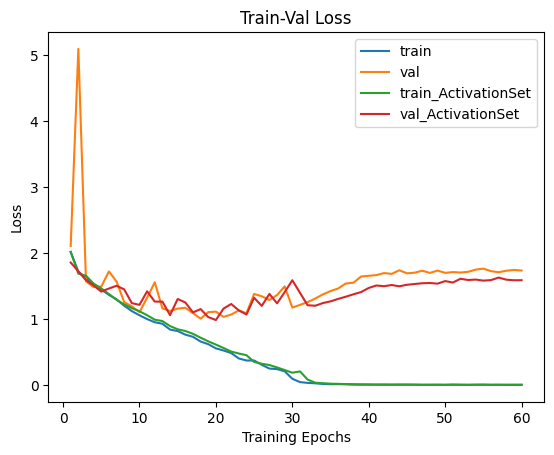

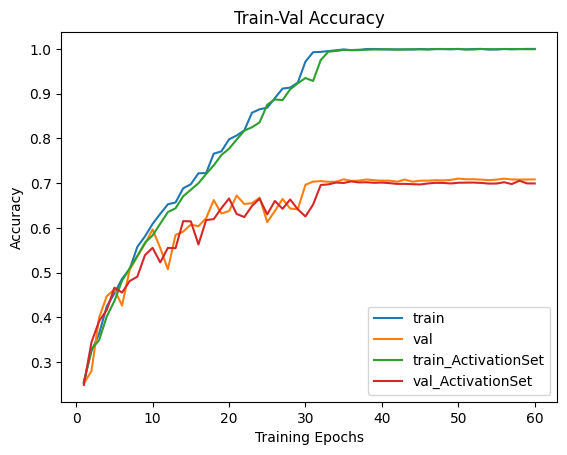

In [12]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.plot(range(1,num_epochs+1),loss_hist_ActivationSet["train"],label="train_ActivationSet")
plt.plot(range(1,num_epochs+1),loss_hist_ActivationSet["val"],label="val_ActivationSet")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.plot(range(1,num_epochs+1),metric_hist_ActivationSet["train"],label="train_ActivationSet")
plt.plot(range(1,num_epochs+1),metric_hist_ActivationSet["val"],label="val_ActivationSet")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [17]:
EstimatedWeight = np.zeros((0, 6))


for i in range(2, 6) :
  for j in range(0, 3) :
    module_0 = 'conv' + str(i) +'_x.' +str(j) + '.residual_function.2.weight_raw'
    module_1 = 'conv' + str(i) +'_x.' +str(j) + '.residual_function.5.weight_raw'

    activationWeight_0 = model_ActivationSet.get_parameter(module_0)
    activationWeight_1 = model_ActivationSet.get_parameter(module_1)

    print(activationWeight_0)
    print(activationWeight_1)

    EstimatedWeight = np.vstack((EstimatedWeight, activationWeight_0.cpu().detach().numpy()))
    EstimatedWeight = np.vstack((EstimatedWeight, activationWeight_1.cpu().detach().numpy()))


Parameter containing:
tensor([0.5893, 0.5920, 0.8934, 0.4792, 0.8917, 0.9472], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([0.3137, 0.0023, 0.5308, 0.6031, 0.7518, 0.4030], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([0.3567, 0.5254, 1.4085, 0.3392, 0.5279, 0.3266], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([ 0.7911, -0.3610,  0.5067,  0.5302,  0.6447,  0.1699], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([0.8393, 0.5792, 0.7840, 0.9086, 1.2552, 0.1015], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([ 1.6239, -0.1986,  1.3068,  0.3620, -0.0130, -0.2922], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([1.3174, 0.2542, 1.2605, 0.5133, 0.2924, 0.2730], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([ 1.1368, -0.2255,  1.7950,  0.9342,  0.7306, -0.4322], device='cuda:0',
       requires_grad=True

In [18]:
print(EstimatedWeight)

mean = EstimatedWeight.mean(axis=0)
print(mean)

[[ 5.89255452e-01  5.91983080e-01  8.93362522e-01  4.79171872e-01
   8.91703844e-01  9.47241485e-01]
 [ 3.13651592e-01  2.31714174e-03  5.30777872e-01  6.03115618e-01
   7.51764417e-01  4.03001368e-01]
 [ 3.56704921e-01  5.25446236e-01  1.40845931e+00  3.39206010e-01
   5.27940392e-01  3.26639593e-01]
 [ 7.91068196e-01 -3.61023962e-01  5.06717145e-01  5.30209541e-01
   6.44690692e-01  1.69941172e-01]
 [ 8.39306355e-01  5.79229712e-01  7.83969343e-01  9.08612370e-01
   1.25522327e+00  1.01497866e-01]
 [ 1.62385952e+00 -1.98617771e-01  1.30682755e+00  3.62019628e-01
  -1.30049605e-02 -2.92203665e-01]
 [ 1.31735766e+00  2.54174292e-01  1.26054871e+00  5.13297737e-01
   2.92425364e-01  2.73021251e-01]
 [ 1.13677621e+00 -2.25522667e-01  1.79504383e+00  9.34212387e-01
   7.30601728e-01 -4.32248861e-01]
 [ 1.28414643e+00  2.55575646e-02  1.23850131e+00  4.11258131e-01
   9.32358146e-01  7.13689905e-03]
 [ 2.34011030e+00 -5.62538862e-01  1.59919083e+00  4.27207649e-01
   4.60625380e-01 -3.7067

In [20]:
class WeightedActivationFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.ReLU = nn.ReLU()
        self.ELU = nn.ELU()
        self.GELU = nn.GELU()
        self.SiLU = nn.SiLU()
        self.Mish = nn.Mish()
        self.Softplus = nn.Softplus()
        #self.Custom = CustomActivationFunction()
        self.functionNum = 6
        self.eps = 1e-7
        self.weight_raw = torch.nn.Parameter(torch.rand(self.functionNum))
        self.EstimatedWeights= torch.tensor( [ 1.28774608, -0.07701044,  1.21537248 , 0.45520385 , 0.36438149 , 0.09928508], dtype=torch.float32)
        #self.tmp_weight = torch.nn.Parameter(torch.rand(1))


    def forward(self, x):
        self.weights = (torch.exp(self.weight_raw) + (self.eps/self.functionNum)) / torch.exp(self.weight_raw).sum()+self.eps
        #self.tmp_out = torch.stack((self.ReLU(x), self.ELU(x), self.GELU(x), self.SiLU(x)))\
        #torch.stack으로 하면 오류 나옴
        #torch.matmul(self.weights, self.tmp_out)
        self.result = self.weights[0]*self.ReLU(x) + self.weights[1]*self.ELU(x) +self.weights[2]*self.GELU(x)+self.weights[3]*self.SiLU(x)+self.weights[4]*self.Mish(x) +self.weights[5]*self.Softplus(x) #+self.weights[6]*self.Custom(x)
        return self.result

In [21]:
class BasicBlock_WeightedActivationFunction(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            WeightedActivationFunction(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck_WeightedActivationFunction(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            WeightedActivationFunction(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            WeightedActivationFunction(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [22]:
def resnet18_WeightedActivationFunction():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34_WeightedActivationFunction():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50_WeightedActivationFunction():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101_WeightedActivationFunction():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152_WeightedActivationFunction():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [23]:
model_WeightedActivationFunction = resnet50_WeightedActivationFunction().to(device)

In [24]:
opt_WeightedActivationFunction = optim.Adam(model_WeightedActivationFunction.parameters(), lr=0.001)
lr_scheduler_WeightedActivationFunction = ReduceLROnPlateau(opt_WeightedActivationFunction, mode='min', factor=0.1, patience=10)

In [27]:
params_train_WeightedActivationFunction = {
    'num_epochs':60,
    'optimizer':opt_WeightedActivationFunction,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler_WeightedActivationFunction,
    'path2weights':'./models/weights_WeightedActivationFunction.pt',
}

In [28]:
model_WeightedActivationFunction, loss_hist_WeightedActivationFunction, metric_hist_WeightedActivationFunction = train_val(model_WeightedActivationFunction, params_train_WeightedActivationFunction)

Epoch 0/59, current lr=0.001


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Get best val_loss
train loss: 1.996363, val loss: 1.724396, accuracy: 29.75, time: 0.6350 min
----------
Epoch 1/59, current lr=0.001
Get best val_loss
train loss: 1.686682, val loss: 1.628466, accuracy: 35.38, time: 1.2683 min
----------
Epoch 2/59, current lr=0.001
Get best val_loss
train loss: 1.573977, val loss: 1.532501, accuracy: 39.89, time: 1.9030 min
----------
Epoch 3/59, current lr=0.001
train loss: 1.514631, val loss: 8.322139, accuracy: 30.01, time: 2.5361 min
----------
Epoch 4/59, current lr=0.001
Get best val_loss
train loss: 1.446969, val loss: 1.419009, accuracy: 46.00, time: 3.1625 min
----------
Epoch 5/59, current lr=0.001
Get best val_loss
train loss: 1.346308, val loss: 1.413842, accuracy: 46.46, time: 3.7910 min
----------
Epoch 6/59, current lr=0.001
Get best val_loss
train loss: 1.284123, val loss: 1.376599, accuracy: 50.48, time: 4.4294 min
----------
Epoch 7/59, current lr=0.001
Get best val_loss
train loss: 1.216388, val loss: 1.335832, accuracy: 51.80, tim

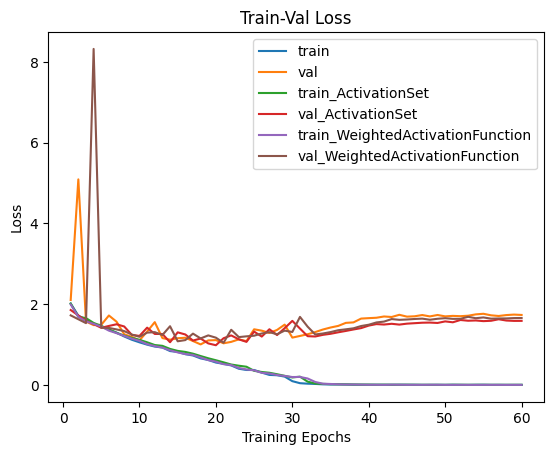

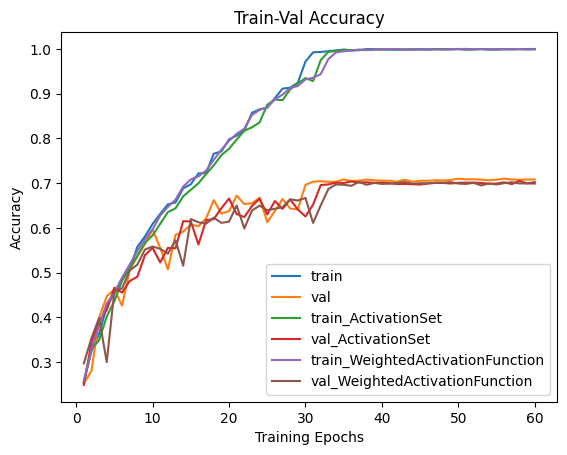

In [29]:
# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.plot(range(1,num_epochs+1),loss_hist_ActivationSet["train"],label="train_ActivationSet")
plt.plot(range(1,num_epochs+1),loss_hist_ActivationSet["val"],label="val_ActivationSet")
plt.plot(range(1,num_epochs+1),loss_hist_WeightedActivationFunction["train"],label="train_WeightedActivationFunction")
plt.plot(range(1,num_epochs+1),loss_hist_WeightedActivationFunction["val"],label="val_WeightedActivationFunction")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.plot(range(1,num_epochs+1),metric_hist_ActivationSet["train"],label="train_ActivationSet")
plt.plot(range(1,num_epochs+1),metric_hist_ActivationSet["val"],label="val_ActivationSet")
plt.plot(range(1,num_epochs+1),metric_hist_WeightedActivationFunction["train"],label="train_WeightedActivationFunction")
plt.plot(range(1,num_epochs+1),metric_hist_WeightedActivationFunction["val"],label="val_WeightedActivationFunction")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()